In [8]:
# standard
import numpy as np
import glob
import os
import pickle
import tqdm
from itertools import product
from joblib import Parallel, delayed
import datetime

# My code
import neuraltda.simpComp as sc
import neuraltda.spectralAnalysis as sa
import neuraltda.topology2 as tp2
import pyslsa

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# file save path
daystr = datetime.datetime.now().strftime('%Y%m%d')
figsavepth = '/home/brad/DailyLog/'+daystr+'/'
print(figsavepth)

/home/brad/DailyLog/20171026/


In [2]:
# The goal is to compute the pairwise distances using the KL divergence between all trials of each stimuli.
# First we set up the parameters for the analysis

# Bird parameters
bps = {'B1083': '/home/brad/krista/B1083/P03S03/', 'B1075': '/home/brad/krista/B1075/P01S03/',
       'B1235': '/home/brad/krista/B1235/P02S01/', 'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/',
       'B1056': '/home/brad/krista/B1056/klusta/phy020516/Pen01_Lft_AP100_ML1300__Site03_Z2500__B1056_cat_P01_S03_1/'}

birds = ['B1083']

# Binning parameters
windt = 10.0                      # milliseconds
dtovr = 0.5*windt                 # milliseconds
segment_info = [0, 0]             # use full Trial
cluster_group = ['Good']          # use just good clusters
comment = 'ForSLSE'               # SLSE Computations
bdfs = {}                         # Dictionary to store bdf
scgfs = {}                         # Dictionary to store simplicial complexes

# Simplicial complex parameters
thresh = 6.0
dim = 1
beta = -0.65

dims = [1,2,3]
betas = [-0.15, -0.65, -0.95]

In [3]:
# Now, bin the data
for bird in birds:
    block_path = bps[bird]
    bfdict = tp2.dag_bin(block_path, windt, segment_info, cluster_group=cluster_group, dt_overlap=dtovr, comment=comment)
    bdf = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]
    print(bdf)
    bdfs[bird] = bdf

/home/brad/krista/B1083/P03S03/binned_data/win-10.0_dtovr-5.0_seg-0-0-ForSLSE/20171019T171241Z-10.0-5.0.binned


In [4]:
# Ok, data binned, now we compute chain groups
for bird in birds:
    block_path = bps[bird]
    #scg_f = sa.computeChainGroups(block_path, bdfs[bird], thresh, comment=comment)
    scg_f = sa.pyslsa_compute_chain_groups_binned(block_path, bdfs[bird], thresh, comment=comment)
    scgfs[bird] = scg_f

Computing Chain Groups...
KeysView(<HDF5 file "20171019T171241Z-10.0-5.0.binned" (mode r)>)
Stim: I_40k, Clusters:None
Calling PySLSA...
Stim: J_40k, Clusters:None
Calling PySLSA...
Stim: K_40k, Clusters:None
Calling PySLSA...
Stim: L_40k, Clusters:None
Calling PySLSA...
Stim: M_40k, Clusters:None
Calling PySLSA...
Stim: N_40k, Clusters:None
Calling PySLSA...
Stim: O_40k, Clusters:None
Calling PySLSA...
Stim: P_40k, Clusters:None
Calling PySLSA...


In [5]:
scgfs[bird] = scg_f


In [ ]:
# Organization of scg file is [stim]
#with open(scgfs[bird], 'rb') as scgf:
#    scg_data = pickle.load(scgf)
#    print(scg_data.keys())

scg_data = scgfs[bird]
# Logic of computation.  For each pair of stimuli, 
# we compute the KL divergence between all pairs of trials.
# so we need an Nstim x Nstim x (Ntrials*Ntrials) matrix to store all the values
stims = list(scg_data.keys())   # Get list of stimuli
Nstim = len(stims)              # Get number of stimuli
Ntrials = 5                     # Hard coded for now...

# Create result array
KL_divs = np.zeros((Nstim, Nstim, Ntrials*Ntrials))

# KL divergence is not symmetric, so we have to do i.e. I/L and L/I
for i, stim1 in enumerate(stims):
    for j, stim2 in enumerate(stims):
        print("Beginning Stimulus pair: ({}, {})".format(stim1, stim2))
        # Extract scgs for each stimulis
        scg1_dat = scg_data[stim1]
        scg2_dat = scg_data[stim2]
        Parallel(n_jobs=7)(delayed(par_KL)(scg1_dat, scg2_dat, trial1, trial2, KL_divs, i, j) 
                           for trial1,trial2 in product(range(Ntrials), range(Ntrials)))


In [ ]:
def par_KL(scg1_dat, scg2_dat, trial1, trial2, KL_divs, i, j):
    scg1 = scg1_dat[trial1]
    scg2 = scg2_dat[trial2]

    # Compute Laplacians
    L1 = sc.compute_laplacian(scg1, dim)
    L2 = sc.compute_laplacian(scg2, dim)

    # Reconcile Laplacians
    # Lsamp : scg1 Ldata : scg2
    if (np.size(L1) > np.size(L2)):
        (L2, L1) = sc.reconcile_laplacians(L2, L1)
    else:
        (L1, L2) = sc.reconcile_laplacians(L1, L2)

    # Compute Divergence
    KL = sc.KLdivergence_lap(L1, L2, beta)
    KL_divs[i, j, trial1*Ntrials + trial2] = KL

In [ ]:
# Non parallel version
# Organization of scg file is [stim]
with open(scgfs[bird], 'rb') as scgf:
    scg_data = pickle.load(scgf)
    print(scg_data.keys())
    
# Logic of computation.  For each pair of stimuli, 
# we compute the KL divergence between all pairs of trials.
# so we need an Nstim x Nstim x (Ntrials*Ntrials) matrix to store all the values
stims = list(scg_data.keys())   # Get list of stimuli
Nstim = len(stims)              # Get number of stimuli
Ntrials = 5                     # Hard coded for now...

# Create result array
KL_divs = np.zeros((Nstim, Nstim, Ntrials*Ntrials))

# KL divergence is not symmetric, so we have to do i.e. I/L and L/I
for i, stim1 in enumerate(stims):
    for j, stim2 in enumerate(stims):
        print("Beginning Stimulus pair: ({}, {})".format(stim1, stim2))
        # Extract scgs for each stimulis
        scg1_dat = scg_data[stim1]
        scg2_dat = scg_data[stim2]
        for (trial1, trial2) in tqdm.tqdm(product(range(Ntrials), range(Ntrials))):
            scg1 = scg1_dat[trial1]
            scg2 = scg2_dat[trial2]

            # Compute Laplacians
            L1 = sc.compute_laplacian(scg1, dim)
            L2 = sc.compute_laplacian(scg2, dim)

            # Reconcile Laplacians
            # Lsamp : scg1 Ldata : scg2
            if (np.size(L1) > np.size(L2)):
                (L2, L1) = sc.reconcile_laplacians(L2, L1)
            else:
                (L1, L2) = sc.reconcile_laplacians(L1, L2)

            # Compute Divergence
            KL = sc.KLdivergence_lap(L1, L2, beta)
            KL_divs[i, j, trial1*Ntrials + trial2] = KL
            
            

In [ ]:
with open(os.path.join(figsavepth, 'KL_divs_{}.pkl'.format(bird)), 'wb') as f:
    pickle.dump(KL_divs, f)

In [9]:
# C version
# Organization of scg file is [stim]
#with open(scgfs[bird], 'rb') as scgf:
#    scg_data = pickle.load(scgf)
#    print(scg_data.keys())
   
scg_data = scgfs[bird]
# Logic of computation.  For each pair of stimuli, 
# we compute the KL divergence between all pairs of trials.
# so we need an Nstim x Nstim x (Ntrials*Ntrials) matrix to store all the values
stims = list(scg_data.keys())   # Get list of stimuli
Nstim = len(stims)              # Get number of stimuli
Ntrials = 5                     # Hard coded for now...

# Create result array
KL_divs = np.zeros((Nstim, Nstim, Ntrials*Ntrials))

# KL divergence is not symmetric, so we have to do i.e. I/L and L/I
for i, stim1 in enumerate(stims):
    for j, stim2 in enumerate(stims):
        print("Beginning Stimulus pair: ({}, {})".format(stim1, stim2))
        # Extract scgs for each stimulis
        scg1_dat = scg_data[stim1]
        scg2_dat = scg_data[stim2]
        for (trial1, trial2) in tqdm.tqdm(product(range(Ntrials), range(Ntrials))):
            scg1 = scg1_dat[trial1]
            scg2 = scg2_dat[trial2]
            KL = pyslsa.KL(scg1, scg2, dim, beta)
            KL_divs[i, j, trial1*Ntrials + trial2] = KL
            
            

0it [00:00, ?it/s]

Beginning Stimulus pair: (I_40k, I_40k)


25it [00:28,  1.00it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (I_40k, J_40k)


25it [00:29,  1.00it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (I_40k, K_40k)


25it [00:27,  1.06it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (I_40k, L_40k)


25it [00:44,  1.49s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (I_40k, M_40k)


25it [00:20,  1.41it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (I_40k, N_40k)


25it [00:26,  1.03it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (I_40k, O_40k)


25it [00:20,  1.38it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (I_40k, P_40k)


25it [00:36,  1.18s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (J_40k, I_40k)


25it [00:32,  1.11it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (J_40k, J_40k)


25it [00:31,  1.13it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (J_40k, K_40k)


25it [00:29,  1.21it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (J_40k, L_40k)


25it [00:41,  1.28s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (J_40k, M_40k)


25it [00:20,  1.77it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (J_40k, N_40k)


25it [00:27,  1.22it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (J_40k, O_40k)


25it [00:21,  1.71it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (J_40k, P_40k)


25it [00:36,  1.00it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (K_40k, I_40k)


25it [00:27,  1.19it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (K_40k, J_40k)


25it [00:28,  1.19it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (K_40k, K_40k)


25it [00:26,  1.27it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (K_40k, L_40k)


25it [00:40,  1.26s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (K_40k, M_40k)


25it [00:18,  1.92it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (K_40k, N_40k)


25it [00:24,  1.27it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (K_40k, O_40k)


25it [00:19,  1.80it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (K_40k, P_40k)


25it [00:34,  1.03it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (L_40k, I_40k)


25it [00:41,  1.27s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (L_40k, J_40k)


25it [00:41,  1.29s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (L_40k, K_40k)


25it [00:40,  1.21s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (L_40k, L_40k)


25it [00:52,  1.67s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (L_40k, M_40k)


25it [00:31,  1.05it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (L_40k, N_40k)


25it [00:38,  1.19s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (L_40k, O_40k)


25it [00:32,  1.02it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (L_40k, P_40k)


25it [00:46,  1.41s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (M_40k, I_40k)


25it [00:18,  1.46it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (M_40k, J_40k)


25it [00:20,  1.46it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (M_40k, K_40k)


25it [00:18,  1.58it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (M_40k, L_40k)


25it [00:32,  1.12s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (M_40k, M_40k)


25it [00:09,  2.86it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (M_40k, N_40k)


25it [00:16,  1.59it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (M_40k, O_40k)


25it [00:10,  2.41it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (M_40k, P_40k)


25it [00:26,  1.17it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (N_40k, I_40k)


25it [00:25,  1.12it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (N_40k, J_40k)


25it [00:26,  1.12it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (N_40k, K_40k)


25it [00:24,  1.18it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (N_40k, L_40k)


25it [00:38,  1.32s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (N_40k, M_40k)


25it [00:16,  1.73it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (N_40k, N_40k)


25it [00:23,  1.18it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (N_40k, O_40k)


25it [00:17,  1.64it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (N_40k, P_40k)


25it [00:32,  1.04s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (O_40k, I_40k)


25it [00:20,  1.41it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (O_40k, J_40k)


25it [00:21,  1.42it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (O_40k, K_40k)


25it [00:19,  1.53it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (O_40k, L_40k)


25it [00:32,  1.13s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (O_40k, M_40k)


25it [00:10,  2.72it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (O_40k, N_40k)


25it [00:17,  1.51it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (O_40k, O_40k)


25it [00:11,  2.46it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (O_40k, P_40k)


25it [00:26,  1.20it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (P_40k, I_40k)


25it [00:35,  1.09it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (P_40k, J_40k)


25it [00:36,  1.09it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (P_40k, K_40k)


25it [00:34,  1.16it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (P_40k, L_40k)


25it [00:46,  1.33s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (P_40k, M_40k)


25it [00:24,  1.69it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (P_40k, N_40k)


25it [00:32,  1.16it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (P_40k, O_40k)


25it [00:26,  1.59it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (P_40k, P_40k)


25it [00:41,  1.05s/it]


In [10]:
with open(os.path.join(figsavepth, 'KL_divs_{}.pkl'.format(bird)), 'wb') as f:
    pickle.dump(KL_divs, f)

In [11]:
KL_divs.shape

(8, 8, 25)

In [12]:
KL_div_mean = np.mean(KL_divs, axis=2)

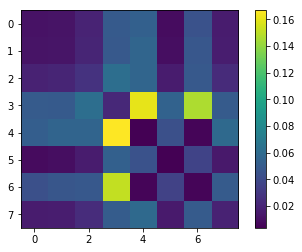

In [13]:
plt.imshow(KL_div_mean, interpolation='nearest')
plt.colorbar()

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Make compressed distance matrix
y = KL_div_mean[np.triu_indices(Nstim, k=1)].flatten()
Z = linkage(y)

In [ ]:
dendrogram(Z)

In [ ]:
d_fam_fam = KL_div_mean[4:, 4:] # familiar familiar
d_fam_nov = KL_div_mean[4:, 0:4] # familiear vs novel
d_nov_fam = KL_div_mean[0:4, 4:] # Novel vs familiar
d_nov_nov = KL_div_mean[0:4, 0:4] # Novel vs Novel

In [14]:
# C version - parameter sweep
# Organization of scg file is [stim]
#with open(scgfs[bird], 'rb') as scgf:
#    scg_data = pickle.load(scgf)
#    print(scg_data.keys())
   
scg_data = scgfs[bird]
# Logic of computation.  For each pair of stimuli, 
# we compute the KL divergence between all pairs of trials.
# so we need an Nstim x Nstim x (Ntrials*Ntrials) matrix to store all the values
dims = [1,2,3]
betas = [-0.15, -0.65, -0.95]
stims = list(scg_data.keys())   # Get list of stimuli
Nstim = len(stims)              # Get number of stimuli
Ntrials = 5                     # Hard coded for now...

# Create result array
# Stimulus x Stimulus x TrialPairs x Dimension x Beta
KL_divs = np.zeros((Nstim, Nstim, Ntrials*Ntrials, len(dims), len(betas)))

for k, beta in enumerate(betas):
    for l, dim in enumerate(dims):
        # KL divergence is not symmetric, so we have to do i.e. I/L and L/I
        for i, stim1 in enumerate(stims):
            for j, stim2 in enumerate(stims):
                print("Beginning Stimulus pair: ({}, {})".format(stim1, stim2))
                # Extract scgs for each stimulis
                scg1_dat = scg_data[stim1]
                scg2_dat = scg_data[stim2]
                for (trial1, trial2) in tqdm.tqdm(product(range(Ntrials), range(Ntrials))):
                    scg1 = scg1_dat[trial1]
                    scg2 = scg2_dat[trial2]
                    KL = pyslsa.KL(scg1, scg2, dim, beta)
                    KL_divs[i, j, trial1*Ntrials + trial2, l, k] = KL
with open(os.path.join(figsavepth, 'KL_divs_{}_parameter_sweep.pkl'.format(bird)), 'wb') as f:
    pickle.dump(KL_divs, f)

0it [00:00, ?it/s]

Beginning Stimulus pair: (I_40k, I_40k)


25it [00:28,  1.01it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (I_40k, J_40k)


25it [00:29,  1.01s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (I_40k, K_40k)


25it [00:27,  1.06it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (I_40k, L_40k)


25it [00:40,  1.42s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (I_40k, M_40k)


25it [00:18,  1.49it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (I_40k, N_40k)


25it [00:25,  1.07it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (I_40k, O_40k)


25it [00:19,  1.42it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (I_40k, P_40k)


25it [00:35,  1.14s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (J_40k, I_40k)


25it [00:29,  1.16it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (J_40k, J_40k)


25it [00:30,  1.16it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (J_40k, K_40k)


25it [00:28,  1.23it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (J_40k, L_40k)


25it [00:42,  1.28s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (J_40k, M_40k)


25it [00:19,  1.83it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (J_40k, N_40k)


25it [00:27,  1.21it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (J_40k, O_40k)


25it [00:22,  1.69it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (J_40k, P_40k)


25it [00:37,  1.02s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (K_40k, I_40k)


25it [00:27,  1.18it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (K_40k, J_40k)


25it [00:29,  1.17it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (K_40k, K_40k)


25it [00:27,  1.25it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (K_40k, L_40k)


25it [00:41,  1.31s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (K_40k, M_40k)


25it [00:18,  1.91it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (K_40k, N_40k)


25it [00:25,  1.25it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (K_40k, O_40k)


25it [00:19,  1.77it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (K_40k, P_40k)


25it [00:35,  1.00it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (L_40k, I_40k)


25it [00:42,  1.30s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (L_40k, J_40k)


25it [00:43,  1.34s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (L_40k, K_40k)


25it [00:41,  1.27s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (L_40k, L_40k)


25it [00:59,  1.97s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (L_40k, M_40k)


25it [00:34,  1.04s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (L_40k, N_40k)


25it [00:44,  1.36s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (L_40k, O_40k)


25it [00:35,  1.04s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (L_40k, P_40k)


25it [00:48,  1.46s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (M_40k, I_40k)


25it [00:19,  1.43it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (M_40k, J_40k)


25it [00:20,  1.44it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (M_40k, K_40k)


25it [00:19,  1.57it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (M_40k, L_40k)


25it [00:33,  1.14s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (M_40k, M_40k)


25it [00:09,  2.84it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (M_40k, N_40k)


25it [00:17,  1.57it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (M_40k, O_40k)


25it [00:10,  2.58it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (M_40k, P_40k)


25it [00:26,  1.20it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (N_40k, I_40k)


25it [00:26,  1.10it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (N_40k, J_40k)


25it [00:27,  1.10it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (N_40k, K_40k)


25it [00:25,  1.14it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (N_40k, L_40k)


25it [00:40,  1.38s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (N_40k, M_40k)


25it [00:17,  1.55it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (N_40k, N_40k)


25it [00:24,  1.15it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (N_40k, O_40k)


25it [00:17,  1.63it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (N_40k, P_40k)


25it [00:33,  1.07s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (O_40k, I_40k)


25it [00:20,  1.39it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (O_40k, J_40k)


25it [00:21,  1.40it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (O_40k, K_40k)


25it [00:19,  1.45it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (O_40k, L_40k)


25it [00:33,  1.15s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (O_40k, M_40k)


25it [00:10,  2.63it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (O_40k, N_40k)


25it [00:18,  1.43it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (O_40k, O_40k)


25it [00:11,  2.45it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (O_40k, P_40k)


25it [00:26,  1.17it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (P_40k, I_40k)


25it [00:36,  1.03s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (P_40k, J_40k)


25it [00:38,  1.06it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (P_40k, K_40k)


25it [00:36,  1.12it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (P_40k, L_40k)


25it [00:49,  1.54s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (P_40k, M_40k)


25it [00:27,  1.56it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (P_40k, N_40k)


25it [00:34,  1.14it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (P_40k, O_40k)


25it [00:27,  1.51it/s]
0it [00:00, ?it/s]

Beginning Stimulus pair: (P_40k, P_40k)


25it [00:43,  1.10s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (I_40k, I_40k)


25it [06:59, 16.77s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (I_40k, J_40k)


25it [07:47, 16.35s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (I_40k, K_40k)


25it [07:32, 15.99s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (I_40k, L_40k)


25it [20:53, 39.14s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (I_40k, M_40k)


25it [04:09, 10.85s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (I_40k, N_40k)


25it [06:04, 15.22s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (I_40k, O_40k)


25it [04:32, 11.40s/it]
0it [00:00, ?it/s]

Beginning Stimulus pair: (I_40k, P_40k)


12it [04:49, 20.50s/it]

KeyboardInterrupt: 

In [15]:
with open('/home/brad/DailyLog/20171026/X101_KL_divs_B1056_parameter_sweep.pkl', 'rb') as f:
    dat = pickle.load(f)

In [16]:
dat.shape

(16, 16, 25, 3, 3)

In [18]:
dat_trial_avg = np.mean(dat, axis=2)

In [29]:
dat_symmetric = (np.transpose(dat, (1, 0, 2, 3, 4)) + dat)/2
dat_symm_trial_avg = np.mean(dat_symmetric, axis=2)

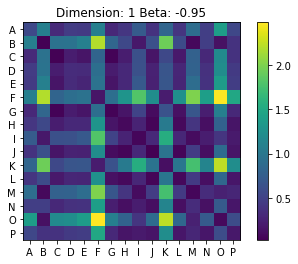

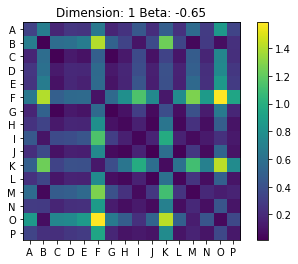

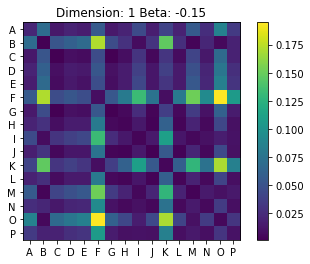

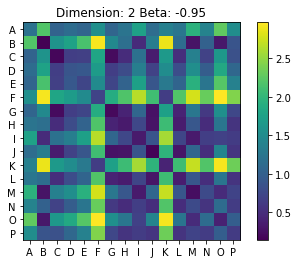

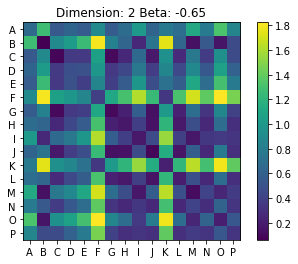

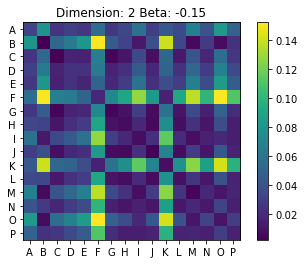

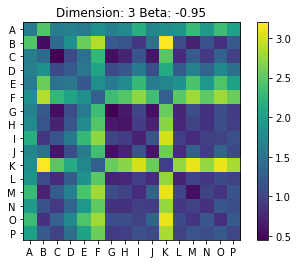

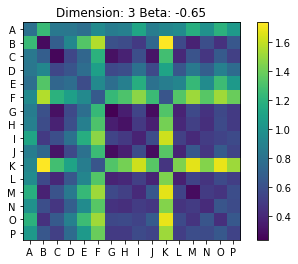

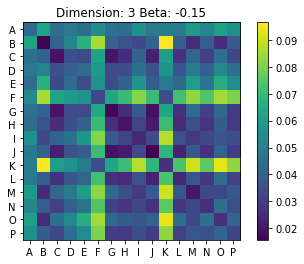

In [30]:
betas = [-0.95,  -0.65, -0.15 ]
dims = [1,2,3]
for ind, dim in enumerate(dims):
    for ind2, beta in enumerate(betas):
        plt.figure()
        plt.imshow(dat_symm_trial_avg[:, :, ind, ind2])
        plt.title("Dimension: {} Beta: {}".format(dim, beta))
        plt.xticks(range(16), ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H',
                               'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P'])
        plt.yticks(range(16), ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H',
                               'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P'])
        plt.colorbar()

In [70]:
nov_inds = range(8, 12)
nb = 8
ne = 12
fam_fam = dat_symmetric[0:4, 0:4, :, :, :]
fam_nov = dat_symmetric[0:4, nb:ne, :, :, :]
nov_nov = dat_symmetric[nb:ne, nb:ne, :, :, :]


In [71]:
dim_ind = 2 # dim 3
beta_ind = 0 # -0.95

fam_fam_sqz = np.ravel(fam_fam[:, :, :, dim_ind, beta_ind])
fam_nov_sqz = np.ravel(fam_nov[:, :, :, dim_ind, beta_ind])
nov_nov_sqz = np.ravel(nov_nov[:, :, :, dim_ind, beta_ind])

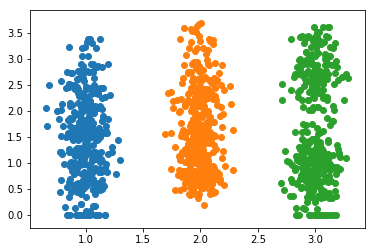

In [72]:
ff_x = np.ones(len(fam_fam_sqz))+0.1*np.random.randn(len(fam_fam_sqz))
fn_x = 2*np.ones(len(fam_nov_sqz))+0.1*np.random.randn(len(fam_nov_sqz))
nn_x = 3*np.ones(len(nov_nov_sqz))+0.1*np.random.randn(len(nov_nov_sqz))

plt.scatter(ff_x, fam_fam_sqz)
plt.scatter(fn_x, fam_nov_sqz)
plt.scatter(nn_x, nov_nov_sqz)

In [68]:
from scipy.stats import ttest_ind

In [73]:
ttest_ind(fam_fam_sqz, fam_nov_sqz)

Ttest_indResult(statistic=-1.6449926767456142, pvalue=0.10036513852135415)

In [76]:
9*16*16*4 / 3600

2.56